# LightGBM Tuning

In [1]:
from src.silence import silence
silence()

import ast
import os
from itertools import product

import numpy as np
import pandas as pd
from darts.models.forecasting.lgbm import LightGBMModel
from tqdm import tqdm

from config import METRIC, METRIC_KWARGS, QUANTILES, ROOT
from src.tuning import (
    compute_validation_score,
    exclude_covid_weights,
    train_validation_split,
)
from src.realtime_utils import load_realtime_training_data

/home/wolffram/RESPINOW-realtime/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 1
OUT_CSV = ROOT / "results" / "tuning" / "gridsearch_lightgbm_are.csv"

In [3]:
NAME = 'lightgbm'

NUM_SAMPLES = 1000
HORIZON = 4

ENCODERS = {
    'datetime_attribute': {'future': ['month', 'weekofyear']}
}

SHARED_ARGS = dict(
    output_chunk_length=HORIZON,
)

# lags_covariates = {
#     'agi-are-DE': 8,
#     'agi-are-00-04': 8,
#     'agi-are-05-14': 8,
#     'agi-are-15-34': 8,
#     'agi-are-35-59': 8,
#     'agi-are-60+': 8,
#     'default_lags': 1
# }

sweep_configuration = {
    "name": f"sari-{NAME}",
    "method": "grid",
    "metric": {"goal": "minimize", "name": "WIS"},
    "parameters": {
        "use_covariates" :  {"values" : [True, False]},
        "use_encoders" :  {"values" : [True]},
        "use_static_covariates" :  {"values" : [False]},
        "sample_weight" : {"values" : ["linear"]}, # "no-covid"
        "lags": {"values": [8]},
        "lags_past_covariates": {"values": [8]}, #[lags_covariates]
        "lags_future_covariates": {"values": [(0, 1)]},
        "num_leaves": {"values": [20, 31, 63]},  # Number of leaves
        "max_depth": {"values": [-1]},  # Max depth of trees
        "learning_rate": {"values": [0.01, 0.05, 0.1]},  # Learning rate
        "n_estimators": {"values": [500, 1000]},  # Number of boosting rounds
        "min_child_samples": {"values": [5, 10, 20]},  # Minimum child samples per leaf
        "subsample": {"values": [0.8]},  # Subsampling ratio
        "colsample_bytree": {"values": [0.8]},  # Feature fraction for building trees
        "reg_alpha": {"values": [0, 0.5, 1.0]},  # L1 regularization
        "reg_lambda": {"values": [0, 0.5, 1.0]},  # L2 regularization
        "subsample_freq": {"values": [1]},  # Subsampling frequency
        "min_split_gain": {"values": [0.0]},  # Minimum gain to split
        "max_bin": {"values": [1024]},  # Maximum number of bins
    }
}

In [4]:
def space_from_sweep(sweep_cfg: dict) -> dict:
    return {k: list(v["values"]) for k, v in sweep_cfg["parameters"].items()}

def iter_configs(space: dict):
    keys = list(space.keys())
    for vals in product(*(space[k] for k in keys)):
        yield dict(zip(keys, vals))

In [5]:
def eval_config(cfg: dict) -> dict:
    lags_past   = cfg["lags_past_covariates"] if cfg["use_covariates"] else None
    lags_future = cfg["lags_future_covariates"] if cfg["use_encoders"]   else None

    model = LightGBMModel(
        lags=cfg["lags"],
        lags_past_covariates=lags_past,
        lags_future_covariates=lags_future,
        num_leaves=cfg["num_leaves"],
        max_depth=cfg["max_depth"],
        learning_rate=cfg["learning_rate"],
        n_estimators=cfg["n_estimators"],
        min_child_samples=cfg["min_child_samples"],
        subsample=cfg["subsample"],
        colsample_bytree=cfg["colsample_bytree"],
        reg_alpha=cfg["reg_alpha"],
        reg_lambda=cfg["reg_lambda"],
        subsample_freq=cfg["subsample_freq"],
        min_split_gain=cfg["min_split_gain"],
        max_bin=cfg["max_bin"],
        use_static_covariates=cfg["use_static_covariates"],
        add_encoders=ENCODERS if cfg["use_encoders"] else None,
        verbose=-1,
        likelihood="quantile",
        quantiles=QUANTILES,
        **SHARED_ARGS,
        random_state=SEED
    )

    weight = custom_weights if cfg["sample_weight"] == "no-covid" else cfg["sample_weight"]
    score = compute_validation_score(
        model, targets_train, targets_validation,
        covariates if cfg["use_covariates"] else None,
        HORIZON, NUM_SAMPLES, METRIC, METRIC_KWARGS,
        sample_weight=weight,
    )

    return {
        "WIS": score,
        **{f"cfg.{k}": v for k, v in cfg.items()},
    }

In [6]:
def run_gridsearch(resume=False):
    space   = space_from_sweep(sweep_configuration)
    configs = list(iter_configs(space))

    param_cols = list(sweep_configuration["parameters"].keys())
    header     = param_cols + ["WIS", "error_flag", "error_msg"]

    if resume and os.path.exists(OUT_CSV):
        gs = pd.read_csv(OUT_CSV)

        # convert string representations into dicts and tuples
        gs["lags_past_covariates"] = gs["lags_past_covariates"].apply(
            lambda x: ast.literal_eval(x) if isinstance(x, str) else x
        )
        gs["lags_future_covariates"] = gs["lags_future_covariates"].apply(
            lambda x: ast.literal_eval(x) if isinstance(x, str) else x
        )

        gs = gs.drop(columns=['WIS', 'error_flag', 'error_msg']).to_dict('records')
        configs = [c for c in configs if c not in gs]

    if not os.path.exists(OUT_CSV):
        pd.DataFrame(columns=header).to_csv(OUT_CSV, index=False)

    total   = len(configs)
    pbar = tqdm(configs, total=total, desc="Grid search", unit="trial")
    for cfg in pbar:
        row = {k: cfg.get(k) for k in param_cols}
        wis = np.nan

        try:
            res = eval_config(cfg)
            wis = float(res.get("WIS", np.nan))
            row.update({"WIS": wis, "error_flag": False, "error_msg": ""})
        except Exception as e:
            row.update({"WIS": np.nan, "error_flag": True, "error_msg": str(e)})

        pd.DataFrame([row], columns=header).to_csv(
            OUT_CSV, mode="a", header=False, index=False
        )

        pbar.set_postfix({
            "WIS": f"{wis:.4f}" if isinstance(wis, (float, np.floating)) and not np.isnan(wis) else "nan",
        })

In [ ]:
targets, covariates = load_realtime_training_data()
targets_train, targets_validation = train_validation_split(targets, 2024)

targets_validation['icosari-sari-DE'].plot(label='validation')
targets_train['icosari-sari-DE'].plot(label='train')

custom_weights = exclude_covid_weights(targets)

In [ ]:
run_gridsearch()

# ARE 

In [7]:
covariates, targets = load_realtime_training_data()
targets_train, targets_validation = train_validation_split(targets, 2024)

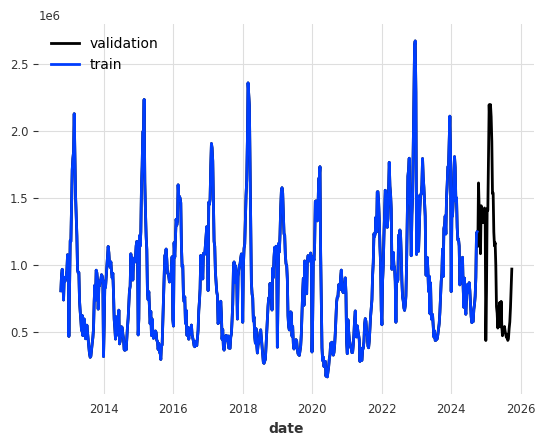

In [9]:
targets_validation['agi-are-DE'].plot(label='validation')
targets_train['agi-are-DE'].plot(label='train')

custom_weights = exclude_covid_weights(targets)

In [ ]:
run_gridsearch()

Grid search:  20%|█▉        | 192/972 [6:49:53<45:01:10, 207.78s/trial, WIS=41164.9545]